<a href="https://colab.research.google.com/github/alirezasakhaei/SPML_Course2023_Homeworks/blob/main/HW01/nn_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name:** Alireza Sakhaeirad

**Student Number:** 98101714




# Neural-Network with Numpy

In this notebook, you are going to write and implement all the components required to create and train a two-layered neural network using NumPy.

## Imports & Seeding:

Importing some common libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(123)
%matplotlib inline

## Preparing the data

You'll train and evaluate your model on [Fashion MNIST](https://en.wikipedia.org/wiki/Fashion_MNIST) dataset. In this section, you'll download Fashion MNIST and split it into training and testing datasets.

In [2]:
from sklearn.datasets import fetch_openml

# Using `fetch_openml`, download `Fashion-MNIST` 
# and save the training data and labels in `X` and `y` respectively.
#############################
# Your code goes here (5 points)
data = fetch_openml(data_id = 40996)
X = data['data'].to_numpy().reshape(-1, 28, 28)
y = data['target'].to_numpy().reshape(-1, 1).astype(np.int32)
#############################

# Normalization:
X = ((X / 255.) - .5) * 2

print(X.shape, y.shape)

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 28, 28) (70000, 1)


In [3]:
from sklearn.model_selection import train_test_split

# Using `train_test_split`, split your data into two sets. 
# Set the test_size to 10000

#############################
# Your code goes here (6 points)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 10000)
#############################

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000, 1) (10000, 28, 28) (10000, 1)


## Prepare training & validation sets

We'll use only 3 classes from Fashion MNIST: Trouser, T-shirt, and Sneaker classes.

The class labels for T-shirt, Trouser, and Sneaker are 0, 1, and 7 respectively.

In this part, you'll limit the testing and training sets to only these three classes.

In [4]:
# Modify `y_train` and `x_train`.
# Only keep the 3 classes mentioned above. 
#############################
# Your code goes here (4 points)
train_indices = [True if y in [0, 1, 7] else False for y in y_train]
train_indices = np.array(train_indices)

if x_train.shape[0] == 60000:
    x_train = x_train[train_indices]
    y_train = y_train[train_indices]

ind7 = np.where(y_train==7)[0]
y_train[ind7]=2
#############################

print(x_train.shape, y_train.shape)

(18017, 28, 28) (18017, 1)


In [5]:
# Modify `y_test` and `x_test`.
# Only keep the 3 classes mentioned above. 
#############################
# Your code goes here (4 points)
test_indices = [True if y in [0, 1, 7] else False for y in y_test]
test_indices = np.array(test_indices)

if x_test.shape[0] == 10000:
    x_test = x_test[test_indices]
    y_test = y_test[test_indices]
#############################

ind7 = np.where(y_test==7)[0]
y_test[ind7]=2

print(x_test.shape, y_test.shape)

(2983, 28, 28) (2983, 1)


In [6]:
assert x_test.shape[0] + x_train.shape[0] == 70000 * 3 // 10

## Linear & Activation Functions

In this part, you'll implement the forward and backward process for the following components:
- Softmax Layer
- Linear Layer
- ReLU Layer
- Sigmoid Layer

### The `Softmax` Layer

In [7]:
class SoftMaxLayer(object):
    def __init__(self):
        self.inp = None
        self.output = None

    def forward(self, x):
        # Write the forward pass for softmax.
        # Save the values required for the backward pass.
        #############################
        # Your code goes here (4 points)
        self.inp = x
        # x = x - np.max(x)
        if np.max(x)>100:
            x=x-np.max(x)
        elif np.min(x)<-100:
            x=x+np.min(x)
        self.output = np.exp(x) / (np.sum(np.exp(x))) 
        #############################
        return self.output

    def backward(self, up_grad):
        # Write the backward pass for softmax.
        #############################
        # Your code goes here (4 points)
        up_grad = up_grad.reshape(-1, 1)
        p = self.output  
        local_grad_mat = np.diag(p) - p.reshape((-1, 1)) @ p.reshape((1, -1))
        down_grad = local_grad_mat @ up_grad
        return down_grad
        #############################

    def __call__(self, x):
        return self.forward(x)


    def step(self, optimizer):
        pass

### The `Linear` Layer 

In [12]:
class Linear:
    def __init__(self, in_dim, out_dim):
        # Initialize the layer's weights and biases
        #############################
        # Your code goes here (2 points)
        self.W = np.random.random((out_dim, in_dim))-0.5
        self.b = np.random.random((out_dim, 1))-0.5
        #############################
        self.dw = 0
        self.db = 0
        
    def forward(self, x):
        # Compute linear layer's output.
        # Save the value(s) required for the backward phase.
        #############################
        # Your code goes here (4 points)
        # print('----')
        # print(np.max(x), np.min(x))
        x = x.reshape(-1, 1)
        self.inp = x
        z = self.W @ x + self.b
        # print(np.max(z), np.min(z))
        #############################
        return z
    
    def backward(self, up_grad):
        # Calculate the gradient with respect to the weights 
        # and biases and save the results.
        #############################
        # Your code goes here (6 points)
        up_grad = up_grad.reshape(-1, 1)
        self.db += up_grad
        self.dw += up_grad @ self.inp.reshape(1, -1)
        # print(up_grad.shape)
        down_grad = up_grad.reshape(1, -1) @ self.W
        #############################
        return down_grad
    
    def __call__(self, x):
        return self.forward(x)

    def step(self, optimizer):
        # Update the layer's weights and biases
        # Update previous_w_update and previous_b_update accordingly
        #############################
        # Your code goes here (5 points)
        self.W = optimizer.get_next_update(self.W, self.dw)
        self.b = optimizer.get_next_update(self.b, self.db)
        #############################

### The `ReLU` Layer

In [14]:
class ReLU:
    def __init__(self):
        self.inp = None

    def forward(self, x):
        # Write the forward pass for ReLU.
        # Save the value(s) required for the backward pass.
        #############################
        # Your code goes here (4 points)
        x = x.reshape(-1, 1)
        self.inp = x
        output = np.maximum(x, 0)
        #############################
        return output
    
    def backward(self, up_grad):
        #############################
        # Your code goes here (4 points)
        up_grad = up_grad.reshape(-1, 1)
        local_grad = np.heaviside(self.inp, 0)
        down_grad = np.multiply(up_grad, local_grad)
        #############################
        return down_grad

    def __call__(self, x):
        return self.forward(x)
        
    def step(self, optimizer):
        pass

### The `sigmoid` Layer

In [15]:
class Sigmoid:
    def forward(self, x):
        #############################
        # Your code goes here (4 points)
        self.inp = x
        self.out = np.divide(1, 1+np.exp(-1 * x))
        #############################
        return self.out
    
    def backward(self, up_grad):
        #############################
        # Your code goes here (4 points)
        up_grad = up_grad.reshape(-1, 1)
        temp = self.out.reshape(-1, 1)
        local_grad = temp - np.power(temp, 2)
        # local_grad = np.mean(local_grad, axis=1)
        # print(local_grad.shape)
        down_grad = np.multiply(up_grad, local_grad)
        #############################
        return down_grad
    
    def __call__(self, x):
        return self.forward(x)

    def step(self, optimizer):
        pass

In [16]:
 x = np.array([1, 2, 3])
 s = Sigmoid()
 s(x)

array([0.73105858, 0.88079708, 0.95257413])

In [17]:
s.backward(np.array([1,1,1]))

array([[0.19661193],
       [0.10499359],
       [0.04517666]])

## `Loss` function :

For this task we are going to use the [Cross-Entropy Loss](https://en.wikipedia.org/wiki/Cross_entropy).

In [18]:
class CELoss():
    def __init__(self):
        pass

    def forward(self, pred, target):
        self.yhat = pred
        self.y = target
        # m = self.y.shape[0]
        # m = 1
        # Commpute and return the loss 
        #############################
        # Your code goes here (8 points)
        # self.m = m
        self.y = self.y.reshape(-1, 1)
        self.yhat = self.yhat.reshape(-1, 1)
        epsilon = 1e-8
        yhat_log = np.log(self.yhat + epsilon).reshape(-1, 1)
        loss = np.sum(np.multiply(-self.y, yhat_log))
        # loss = loss / m
        self.loss = loss
        return self.loss
        #############################
        
    def __call__(self, pred, target):
        return self.forward(pred, target)

    def backward(self):
        # Derivative of loss_fn with respect to a the predicted label.
        # Use `self.y` and `self.yhat` to compute and return `grad`.
        #############################
        # Your code goes here (6 points)
        # m = self.m
        epsilon = 1e-8
        self.y = self.y.reshape(-1, 1)
        grad = -np.divide(self.y, self.yhat + epsilon)
        # grad = np.mean(grad, axis=1)
        grad = grad.reshape(-1, 1)
        #############################
        return grad

## Optimizer

In this section, you'll implement an optimizer classes


In [32]:
class GradientDescent(object):
    def __init__(self, lr):
        self.lr = lr

    def get_next_update(self, x, dx):
        # Compute the new value for 'x' and return the result
        #############################
        # Your code goes here (2 points)
        x = x - self.lr * (dx/np.linalg.norm(dx))
        return x
        #############################

## The Model
Now you'll write the base class for a multi-layer perceptron network.

In [20]:
class MLP:
    def __init__(self, layers, loss_fn, optimizer):
        self.layers = layers 
        self.losses  = [] 
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def zero_grad(self):
        for layer in self.layers:
            if type(layer) == type(Linear(1, 1)):
                layer.dw = 0
                layer.db = 0

    def forward(self, inp):
        # Pass `inp` to all the layers sequentially
        # and return the result.
        #############################
        # Your code goes here (4 points)
        # print(inp)
        for layer in self.layers:
            # print('-------------------------')
            inp = layer(inp)
            # print(inp)
        return inp
        #############################
        
    def loss(self, pred, label):
        loss = self.loss_fn.forward(pred, label)
        return loss

    def backward(self):
        # Start with loss function's gradient and 
        # do the backward pass on all the layers.
        #############################
        # Your code goes here (5 points)
        down_grad = self.loss_fn.backward()
        for layer in reversed(self.layers):
            down_grad = layer.backward(down_grad)
        #############################
        
    def update(self):
        for layer in self.layers:
            layer.step(self.optimizer)

The following cell encodes training labels into a one-hot representation with 3 classes.

In [21]:
def onehot_enc(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

y_train = onehot_enc(y_train, 3)

In [22]:
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [55]:
def train(model, epochs, x, y):
    losses = []
    model.zero_grad()
    for n in tqdm(range(epochs)):
        # First do the forward pass. Next, compute the loss.
        # Then do the backward pass and finally, update the parameters.
        #############################
        # Your code goes here (4 points)
        loss = 0
        for i in range(x_train.shape[0]):

            x = x_train[i]
            y = y_train[i]
            yhat = model.forward(x)
            loss += model.loss(yhat, y)
            model.backward()

            if (i%1024==0):
                model.update()
                model.zero_grad()

        acc = calc_acc(model)
        loss = loss / x_train.shape[0]
        losses.append(loss)
        #############################
        print(f"Loss and Acc at {n}: {loss:.3f}, {acc:.3f}")
    return losses

In [168]:
l=Linear(784,50)
l2=ReLU()
l3=Linear(50,50)
l4=Linear(50,3)
l5=SoftMaxLayer()


In [169]:
l5(l4(l2(l3(l2(l(x_train[0]))))))

array([[0.82974933],
       [0.05842853],
       [0.11182214]])

In [58]:
# Instantiate the `MLP` with the following structure:
#     Linear with 50 units --> ReLU --> Linear with 50 units --> ReLU --> Linear with 3 units --> Sigmoid --> Softmax
# Use GradientDescent as the optimizer, set the learning rate to 0.001, and use CELoss as the loss function.
#############################
# Your code goes here (4 points)
layers = [Linear(784, 50), ReLU(), Linear(50, 50), ReLU(), Linear(50, 3), Sigmoid(), SoftMaxLayer()]
# layers = [Linear(784,3), SoftMaxLayer()]
nn = MLP(layers, CELoss(), GradientDescent(0.001))
#############################
# nn.forward(x_train[100])
epochs = 50


# Train the network using only `x_train` and `y_train` (no validation)
losses = train(nn, epochs, x_train, y_train)

  2%|▏         | 1/50 [00:11<09:21, 11.46s/it]

Loss and Acc at 0: 1.130, 0.369


  4%|▍         | 2/50 [00:22<09:05, 11.37s/it]

Loss and Acc at 1: 1.136, 0.374


  6%|▌         | 3/50 [00:35<09:31, 12.16s/it]

Loss and Acc at 2: 1.147, 0.379


  8%|▊         | 4/50 [00:47<09:02, 11.80s/it]

Loss and Acc at 3: 1.162, 0.387


 10%|█         | 5/50 [00:58<08:46, 11.71s/it]

Loss and Acc at 4: 1.177, 0.393


 12%|█▏        | 6/50 [01:10<08:32, 11.64s/it]

Loss and Acc at 5: 1.186, 0.401


 14%|█▍        | 7/50 [01:21<08:17, 11.58s/it]

Loss and Acc at 6: 1.187, 0.409


 16%|█▌        | 8/50 [01:32<08:00, 11.44s/it]

Loss and Acc at 7: 1.177, 0.417


 18%|█▊        | 9/50 [01:42<07:30, 10.99s/it]

Loss and Acc at 8: 1.157, 0.419


 20%|██        | 10/50 [01:54<07:26, 11.17s/it]

Loss and Acc at 9: 1.134, 0.420


 22%|██▏       | 11/50 [02:05<07:19, 11.26s/it]

Loss and Acc at 10: 1.115, 0.420


 24%|██▍       | 12/50 [02:17<07:09, 11.30s/it]

Loss and Acc at 11: 1.105, 0.422


 26%|██▌       | 13/50 [02:28<06:58, 11.31s/it]

Loss and Acc at 12: 1.099, 0.424


 28%|██▊       | 14/50 [02:39<06:47, 11.33s/it]

Loss and Acc at 13: 1.096, 0.424


 30%|███       | 15/50 [02:50<06:29, 11.13s/it]

Loss and Acc at 14: 1.094, 0.427


 32%|███▏      | 16/50 [03:00<06:08, 10.84s/it]

Loss and Acc at 15: 1.094, 0.430


 34%|███▍      | 17/50 [03:12<06:04, 11.05s/it]

Loss and Acc at 16: 1.094, 0.430


 36%|███▌      | 18/50 [03:23<05:56, 11.13s/it]

Loss and Acc at 17: 1.094, 0.430


 38%|███▊      | 19/50 [03:35<05:49, 11.26s/it]

Loss and Acc at 18: 1.095, 0.434


 40%|████      | 20/50 [03:47<05:49, 11.65s/it]

Loss and Acc at 19: 1.096, 0.443


 42%|████▏     | 21/50 [03:59<05:41, 11.76s/it]

Loss and Acc at 20: 1.097, 0.454


 44%|████▍     | 22/50 [04:11<05:27, 11.70s/it]

Loss and Acc at 21: 1.097, 0.463


 46%|████▌     | 23/50 [04:22<05:13, 11.63s/it]

Loss and Acc at 22: 1.097, 0.468


 48%|████▊     | 24/50 [04:32<04:48, 11.10s/it]

Loss and Acc at 23: 1.098, 0.476


 50%|█████     | 25/50 [04:43<04:39, 11.18s/it]

Loss and Acc at 24: 1.098, 0.479


 52%|█████▏    | 26/50 [04:55<04:29, 11.25s/it]

Loss and Acc at 25: 1.098, 0.478


 54%|█████▍    | 27/50 [05:06<04:19, 11.27s/it]

Loss and Acc at 26: 1.098, 0.482


 56%|█████▌    | 28/50 [05:18<04:11, 11.42s/it]

Loss and Acc at 27: 1.098, 0.485


 58%|█████▊    | 29/50 [05:29<03:59, 11.43s/it]

Loss and Acc at 28: 1.098, 0.485


 60%|██████    | 30/50 [05:41<03:47, 11.38s/it]

Loss and Acc at 29: 1.098, 0.481


 62%|██████▏   | 31/50 [05:51<03:27, 10.93s/it]

Loss and Acc at 30: 1.099, 0.479


 64%|██████▍   | 32/50 [06:02<03:16, 10.94s/it]

Loss and Acc at 31: 1.099, 0.478


 66%|██████▌   | 33/50 [06:13<03:08, 11.10s/it]

Loss and Acc at 32: 1.099, 0.477


 68%|██████▊   | 34/50 [06:24<02:59, 11.20s/it]

Loss and Acc at 33: 1.099, 0.477


 70%|███████   | 35/50 [06:36<02:50, 11.35s/it]

Loss and Acc at 34: 1.099, 0.476


 72%|███████▏  | 36/50 [06:47<02:37, 11.26s/it]

Loss and Acc at 35: 1.099, 0.474


 74%|███████▍  | 37/50 [06:58<02:24, 11.14s/it]

Loss and Acc at 36: 1.099, 0.474


 76%|███████▌  | 38/50 [07:10<02:17, 11.48s/it]

Loss and Acc at 37: 1.099, 0.473


 78%|███████▊  | 39/50 [07:21<02:04, 11.33s/it]

Loss and Acc at 38: 1.099, 0.473


 80%|████████  | 40/50 [07:31<01:48, 10.82s/it]

Loss and Acc at 39: 1.099, 0.475


 82%|████████▏ | 41/50 [07:42<01:37, 10.84s/it]

Loss and Acc at 40: 1.099, 0.481


 84%|████████▍ | 42/50 [07:53<01:26, 10.82s/it]

Loss and Acc at 41: 1.099, 0.481


 86%|████████▌ | 43/50 [08:03<01:15, 10.80s/it]

Loss and Acc at 42: 1.099, 0.484


 88%|████████▊ | 44/50 [08:14<01:04, 10.81s/it]

Loss and Acc at 43: 1.099, 0.488


 90%|█████████ | 45/50 [08:25<00:54, 10.81s/it]

Loss and Acc at 44: 1.099, 0.494


 92%|█████████▏| 46/50 [08:36<00:43, 10.82s/it]

Loss and Acc at 45: 1.099, 0.498


 94%|█████████▍| 47/50 [08:47<00:32, 10.79s/it]

Loss and Acc at 46: 1.099, 0.502


 96%|█████████▌| 48/50 [08:57<00:21, 10.75s/it]

Loss and Acc at 47: 1.099, 0.509


 98%|█████████▊| 49/50 [09:07<00:10, 10.43s/it]

Loss and Acc at 48: 1.099, 0.510


100%|██████████| 50/50 [09:18<00:00, 11.17s/it]

Loss and Acc at 49: 1.099, 0.514


Let's plot the loss value for each iteration

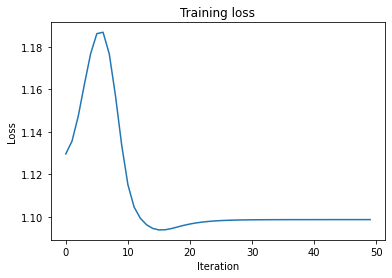

In [60]:
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Iteration")
plt.ylabel("Loss");

**Let's also check our model's performance using the `accuracy` metric on the `testing` dataset**

In [61]:
# Compute the accuracy on the testing set
#############################
# Your code goes here (7 points)
def calc_acc(model):
    c = 0
    yhat = np.zeros(y_test.shape[0])
    for i in range(yhat.shape[0]):
        pred = model.forward(x_test[i])
        pred = np.argmax(pred)
        if int(pred)==y_test[i]:
            c += 1

    acc = c / y_test.shape[0]
    return acc

acc = calc_acc(nn)
#############################

print(acc)

0.5139121689574254
